# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-3])

# add integration folder to current working path
sys.path.append(parent_directory+"/Src/integration")

# add utils folder to current working path
sys.path.append(parent_directory+"/Src/utils")

# add HyperbolicsLCS folder to current working path
sys.path.append(parent_directory+"/Demos/HyperbolicLCS")

CPU times: user 102 µs, sys: 84 µs, total: 186 µs
Wall time: 127 µs


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we extract hyperbolic (attracting/repelling) LCS in the Agulhas region from the AVISO dataset. The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
* Define computational parameters (such as the number of cores) and variables
* Define spatio-temporal domain over which to compute the hyperbolic LCS. The spatial domain defines the meshgrid from where to launch the trajectories and the temporal domain specifies the time-interval (in days).
* Interpolate velocity from the gridded data using a cubic spline interpolation
* Compute Cauchy Green strain tensor over meshgrid of initial conditions over the specified time-interval
* Compute repelling LCS (shrinklines) at initial time
* Compute attracting LCS (stretchlines) at initial time

# Import data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../Data/Aviso/Agulhas_AVISO.mat')

U = mat_file['u'][:,:,:]
V = mat_file['v'][:,:,:]
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t'][:,:]

CPU times: user 18.1 ms, sys: 12.5 ms, total: 30.6 ms
Wall time: 32.5 ms


# Data/Parameters for dynamical system

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 25

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
# Spatio-temporal domain of dynamical system

In [5]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size
dt = .1

time = np.arange(t0, tN+dt, dt)

# domain boundary (in degrees)
xmin = -1
xmax = 3
ymin = -34
ymax = -30

# spacing of meshgrid (in degrees)
dx = 0.015
dy = 0.015

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 617 µs, sys: 578 µs, total: 1.19 ms
Wall time: 554 µs


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 125 ms, sys: 19.4 ms, total: 144 ms
Wall time: 147 ms


# Cauchy Green (CG) strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The method *DS._spin_tensor(x, t)* computes the rate of strain tensor at point $ \mathbf{x} $  at time $ t $ by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{20}, \dfrac{1}{100}] $. The computations are parallelized.

In [7]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import Rate of Strain function
from ipynb.fs.defs.CauchyGreen import CauchyGreen

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

def parallel_C(i):
    
    C_parallel = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(C_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # Compute gradient of flowmap
        gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
        # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
        gradFmap_t0_tN = gradFmap[:,:,-1]
        
        # Compute CG tensor
        C_parallel[j, :, :] = CauchyGreen(gradFmap_t0_tN)
    
    return C_parallel

C = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_C)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/268 [00:00<?, ?it/s]

CPU times: user 18 s, sys: 4.45 s, total: 22.5 s
Wall time: 12min 41s


# Eigenvalues/Eigenvectors of Cauchy Green strain tensor

We now compute the properties of the rate of Cauchy Green strain tensor 'C' such as the eigenvalues 'eig1', 'eig2' and eigenvectors 'e1', 'e2'.

In [8]:
# Import eigenvalues/eigenvectors calculator
from ipynb.fs.defs.eigen import eigen

eig1 = C[:,:,0,0].copy()*np.nan
eig2 = C[:,:,0,0].copy()*np.nan
e1 = np.zeros((C.shape[0], C.shape[1], 2))
e2 = np.zeros((C.shape[0], C.shape[1], 2))

#iterate over meshgrid
for i in range(X_domain.shape[0]):
    
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute eigenvalues of rate of strain
        eig1[i,j], eig2[i,j], e1[i,j,:], e2[i,j,:] = eigen(C[i,j,:,:])

# Shrinklines (Repelling LCS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t_0, t_N),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ \lambda_1 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ \lambda_2(\mathbf{x}_0;t_0, t_N) $ among all neighbouring shrinklines.

In [9]:
from ipynb.fs.defs.tensorlines import _tensorlines

# step-size used for integration with respect to parameter 's'
step_size = 0.01

# threshold distance to locate local maxima in the 'eig2' field of 'C'
max_distance = 0.1

# maximum length of shrinkline
max_length = 5

# compute shrinklines
shrinklines = _tensorlines(X_domain, Y_domain, eig2, e1, max_distance, max_length, step_size)

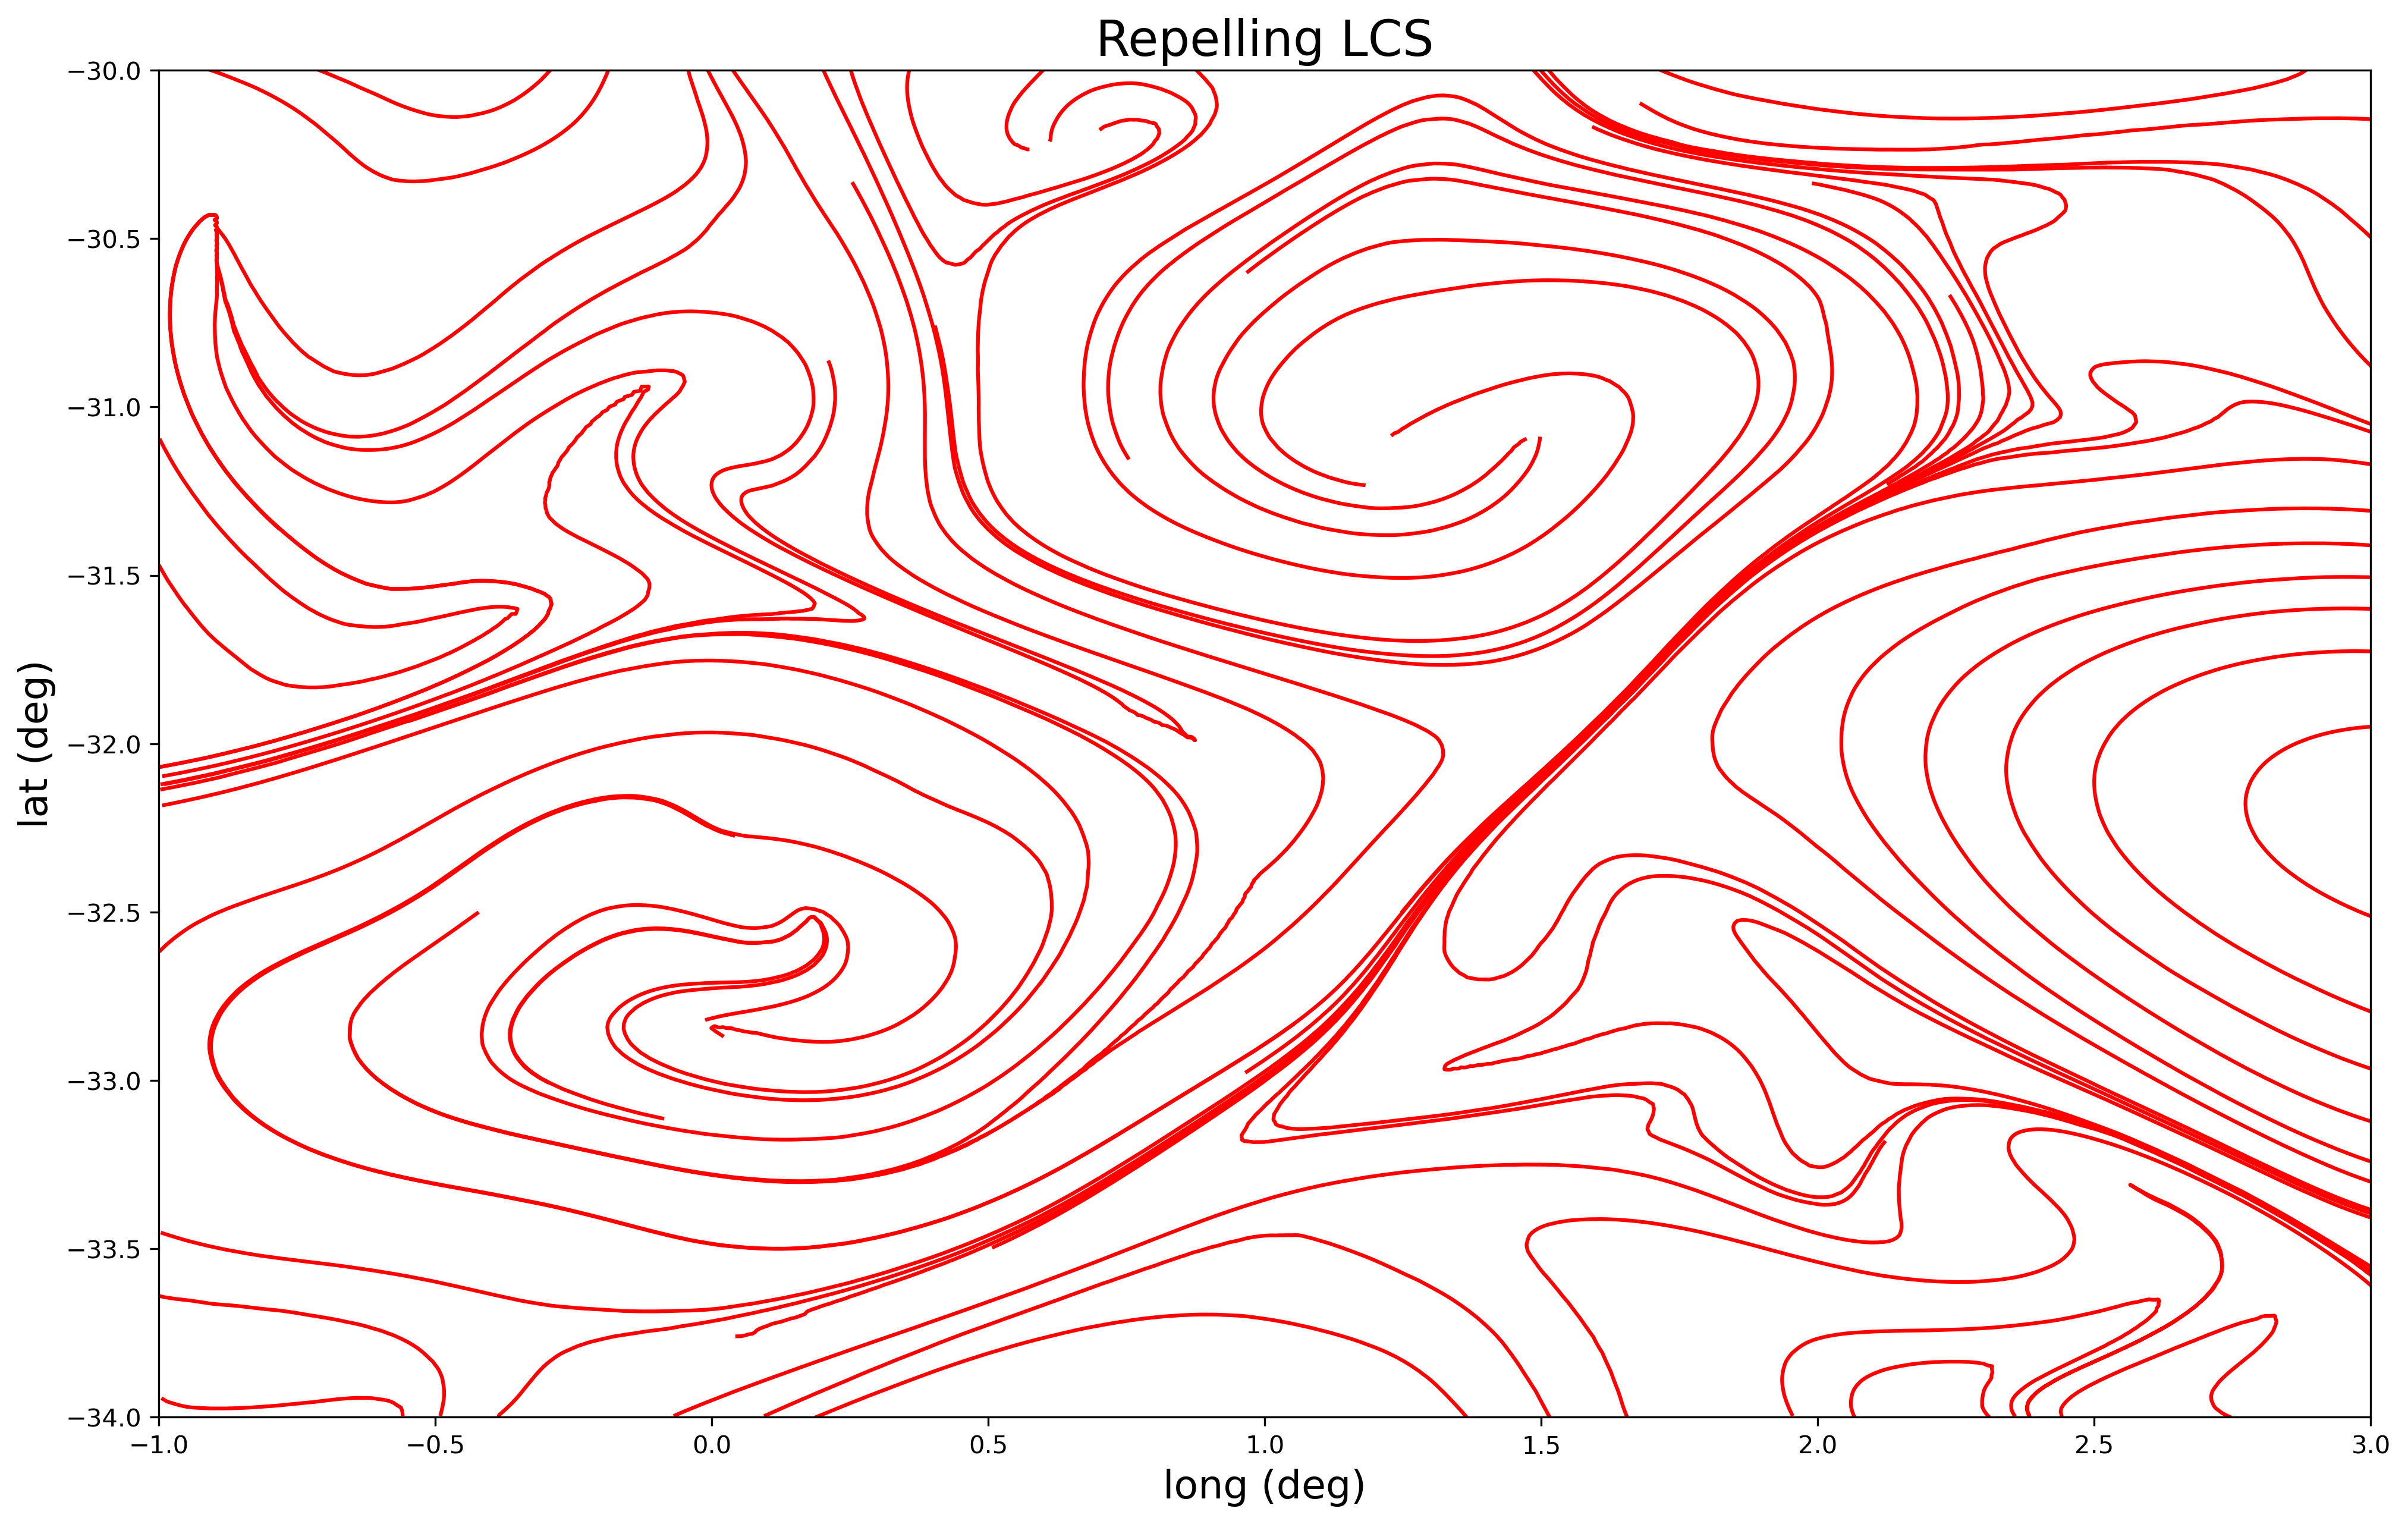

In [10]:
###################################### PLOT REPELLING LCS ######################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

for i in range(len(shrinklines[0])):
    ax.plot(shrinklines[0][i], shrinklines[1][i], c = 'r')
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
#cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
#cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Repelling LCS", fontsize = 20)
plt.show();

# Stretchlines (Attracting LCS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t_0, t_N),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ \lambda_2 $ of $ C_{t_0}^{t_N}(\mathbf{x}_0) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ \lambda_1 = \lambda_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting LCSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ \lambda_1(\mathbf{x}_0;t_0, t_N) $ among all neighbouring stretchlines.

In [11]:
from ipynb.fs.defs.tensorlines import _tensorlines

# step-size used for integration with respect to parameter 's'
step_size = 0.01

# threshold distance to locate local maxima in the 'eig2'
max_distance = 0.1

# maximum length of stretchline
max_length = 5

# compute stretchlines
stretchlines = _tensorlines(X_domain, Y_domain, eig2, e2, max_distance, max_length, step_size)

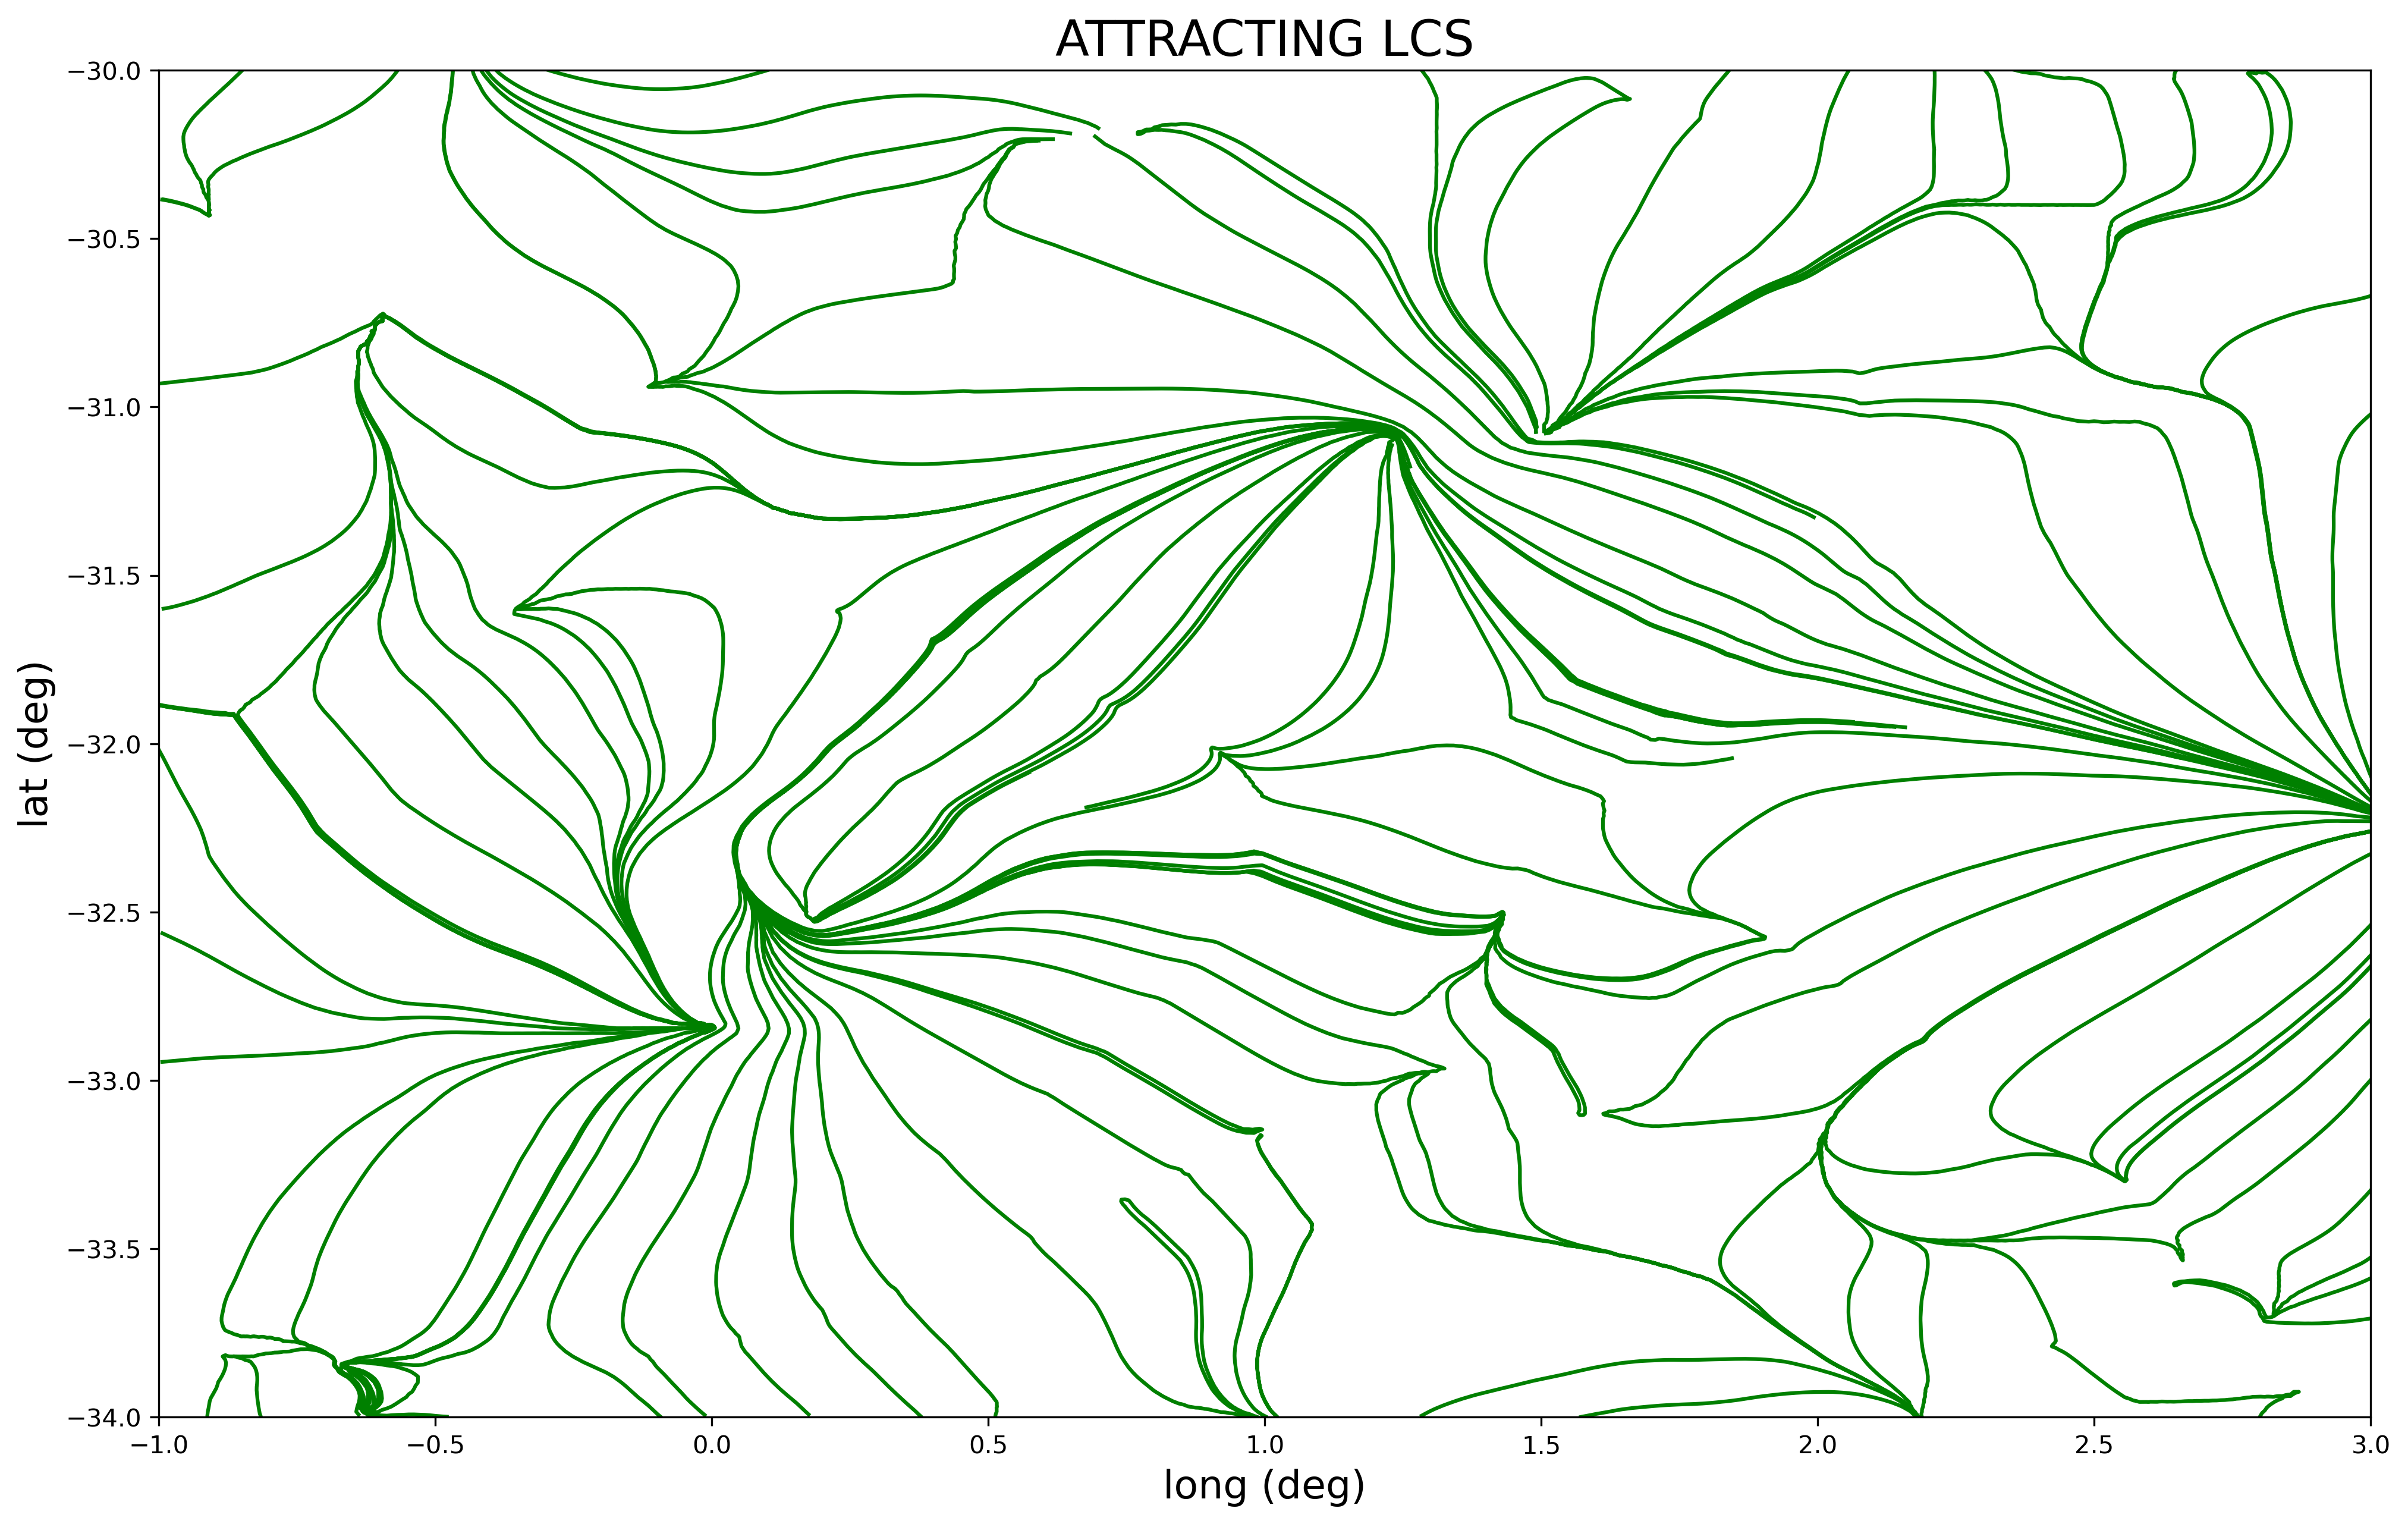

In [12]:
###################################### PLOT ATTRACTING LCS ######################################

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

for i in range(len(stretchlines[0])):
    ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'g')
    
# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
#cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
#cbar.ax.set_ylabel(r'$ \m $', rotation = 0, fontsize = 16)

# Title
ax.set_title("ATTRACTING LCS", fontsize = 20)
plt.show();